# Decision Making

Simple decision-making simulations with 4 parameters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
import warnings
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import seaborn 

warnings.filterwarnings("ignore")

## Context-Free Simple
- STEP 1: Simulate function (n,B,r -> E[U])
- STEP 2: Iterate STEP 1 function with different B -> best U given same n,r 
- STEP 3: Iterate STEP 2 function with different r -> optimal relationship between B and n

In [18]:
#Params
N = 1000
n = 20
B = 1
r = 0.4

STEP 1:
1. Generate random consideration set - 
    - Bivariate Normal with param <b>r</b> and <b>N</b> samples
        -  Dimensions: (CF utility, CS utility)
2. Sample <b>n</b> options from set following softmax scheme sensitive to CF utility (higher CF-utility has a higher chance to be sampled, param <b>$\beta$</b>) 
3. Return max CS utility given <b>n</b> options 

In [20]:
def sim(N, n, B, r, show):
    # Generate bivariate standard normal samples with correlation r
    S = np.random.multivariate_normal([0, 0], [[1, r], [r, 1]], N)

    # Select n points from S using softmax schema with respect to 'CF'
    cf = S[:, 0]
    softmax_probs = np.exp(B * cf) / np.sum(np.exp(B * cf))

    # Replace NaN values with zeros
    softmax_probs = np.nan_to_num(softmax_probs, nan=0.0)

    indices = np.random.choice(N, n, p=softmax_probs, replace=False)
    X = S[indices]

    # Plot S on a scatter plot
    if show:
        plt.scatter(S[:, 0], S[:, 1], alpha=0.5)
        plt.scatter(X[:, 0], X[:, 1], color='red', label='Selected Points')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Scatter Plot of S with Selected Points')
        plt.legend()
        plt.show()

    return np.max(X[:, 1])


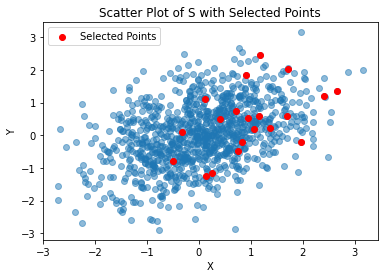

2.448149533932439


In [21]:
print(sim(N,n,B,r, True))

STEP 2:
- Run STEP 1 for <b>j</b> different $\beta$, storing the average max utility (E[U]) of <b>k</b> simulations for each beta. Return the $\beta$ with the average max utility ($\hat{\beta}$).

In [24]:
def sim_betas(a,b,r,n,show):
    # Create an empty dataframe to store the results
    df_u = pd.DataFrame(columns=['B', 'Mean_U', 'Std_U'])

    j = 20
    k = 1000

    # Iterate with different values of B
    for B in range(j):
        u_values = []

        # Choosing random B
        random_B = np.exp(np.random.uniform(a,b))

        # Several trials of same B
        for _ in range(k):
            u = sim(N, n, random_B, r, False)
            u_values.append(u)

        # Calculate the mean and standard deviation of u_values
        df_u = df_u.append({'B': random_B, 'Mean_U': np.mean(u_values), 'Std_U': np.std(u_values)}, ignore_index=True)


    # Plot the scatter plot with error bars
    if show:
        plt.errorbar(np.log(df_u['B']), df_u['Mean_U'], yerr=df_u['Std_U'], fmt='o')
        plt.xlabel('log(B)')
        plt.ylabel('Mean of U')
        plt.title('Scatter Plot of log(B) vs Mean of U with Error Bars')
        plt.show()
        print(df_u.loc[df_u['Mean_U'].idxmax()])
        
    return df_u.loc[df_u['Mean_U'].idxmax()]


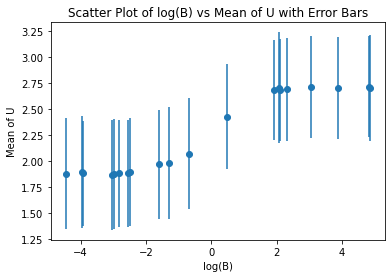

B         123.308955
Mean_U      2.711193
Std_U       0.485264
Name: 9, dtype: float64


In [25]:
df = sim_betas(-5,5,r,n,True)

(STEP 2.5):
- Run STEP 2 for <b>j</b> randomly sampled ns (within a specified interval), storing the average max utility (E[U]) of <b>k</b> simulations for each n (and beta). Return a dataframe with average max E[U] associated with each n and $\beta$.

In [8]:
def sim_ns(lst, r, show):    
    # Create an empty dataframe to store the results
    df = pd.DataFrame(columns=['n', 'b', 'u'])

    a = -4
    b = 4

    s = 50

    # Iterate over the n values
    for n in range(len(lst)):
        # Repeat the simulation 10 times for each n
        df_betas = pd.DataFrame(columns=['B', 'Mean_U'])
        for _ in range(s):
            # Call the sim_betas function and store the result in the dataframe
            u = sim_betas(a, b, r, lst[n], False)
            df_betas = pd.concat([df_betas, pd.DataFrame({'B': [u[0]], 'Mean_U': [u[1]]})])
        
        # Append the results to the dataframe
        df = pd.concat([df, pd.DataFrame({'n': [lst[n]] * len(df_betas), 'b': df_betas['B'], 'u': df_betas['Mean_U']})], ignore_index=True)

    # Create a 3D plot
    if show:
        g = seaborn.FacetGrid(df, row="n", aspect=2)
        g.map(plt.scatter, "b", "u", edgecolor="w").add_legend()

        plt.show()
        # fig = plt.figure()
        # ax = fig.add_subplot(111, projection='3d')
        # ax.scatter(df['b'], df['n'], df['u'])
        # ax.set_xlabel('b')
        # ax.set_ylabel('n')
        # ax.set_zlabel('u')
        # plt.title('3D Scatter Plot of n, b, and u')

        # # Fit a plane to the data points
        # x = df['b']
        # y = df['n']
        # z = df['u']
        # model = LinearRegression()
        # model.fit(np.column_stack((x, y)), z)
        # xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 10), np.linspace(y.min(), y.max(), 10))
        # zz = model.predict(np.column_stack((xx.ravel(), yy.ravel())))
        # zz = zz.reshape(xx.shape)

        # # Plot the plane of best fit
        # ax.plot_surface(xx, yy, zz, alpha=0.5)

        # plt.show()

    return df

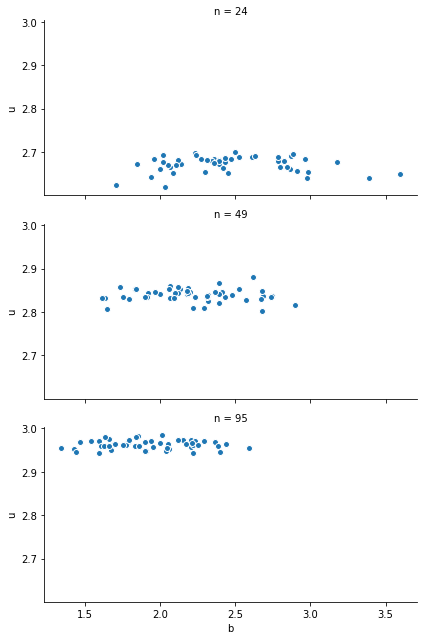

In [9]:
def generate_random_integers(n):
    return np.random.randint(low=1, high=100, size=n).tolist()

df_c = sim_ns(generate_random_integers(3),r, True)

STEP 3: Run STEP 2.5 to determine the average max E[U] associated with n and $\beta$ for different r's. Returns coefficients of multiple regression E[E[U|n, $\beta$, r]] ~ N + B 

In [10]:
def sim_rs(r_values, show):
    # Create an empty dataframe to store the output dataframes
    df = pd.DataFrame()

    # Iterate through the correlation coefficients
    for r in r_values:
        # Call the sim_ns function and store the output dataframe
        output_df = sim_ns([1, 50, 100], r, False)

        # Add a new column to the output dataframe with the correlation coefficient
        output_df['r'] = r

        # Append the output dataframe to the main dataframe
        df = df.append(output_df, ignore_index=True)

    if show:

        g = seaborn.FacetGrid(df, row="n", col="r", aspect=1.5)
        g.map(plt.scatter, "b", "u", edgecolor="w")
        g.add_legend()
        plt.show()

    return df
        

    #     ax = fig.add_subplot(111, projection='3d')
        
    #     # Iterate through unique r values and assign distinct colors
    #     unique_r_values = df['r'].unique()
    #     colors = plt.cm.get_cmap('tab10', len(unique_r_values))
        
    #     # Plot the points with distinct colors based on r values
    #     for i, r_value in enumerate(unique_r_values):
    #         subset_df = df[df['r'] == r_value]
    #         ax.scatter(subset_df['b'], subset_df['n'], subset_df['u'], c=colors(i), label=f'r={r_value}')
            
    #         # Fit a plane to the data points
    #         x = subset_df['b']
    #         y = subset_df['n']
    #         z = subset_df['u']
    #         model = LinearRegression()
    #         model.fit(np.column_stack((x, y)), z)

    #         slope = model.coef_
    #         intercept = model.intercept_
    #         y_pred = model.predict(X)
    #         r2 = r2_score(y, y_pred)

    #         print(f'R-value: {r_value}. u = {slope[0]} * n + {slope[1]} * b + {intercept}. R^2 = {r2}')

    #         xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 10), np.linspace(y.min(), y.max(), 10))
    #         zz = model.predict(np.column_stack((xx.ravel(), yy.ravel())))
    #         zz = zz.reshape(xx.shape)

    #         # Plot the plane of best fit with the same color as the points
    #         ax.plot_surface(xx, yy, zz, alpha=0.5, color=colors(i))

        
    #     ax.set_xlabel('b')
    #     ax.set_ylabel('n')
    #     ax.set_zlabel('u')
    #     plt.title('3D Scatter Plot of n, b, and u')
    #     plt.legend()
    #     plt.show()
        
    # return df


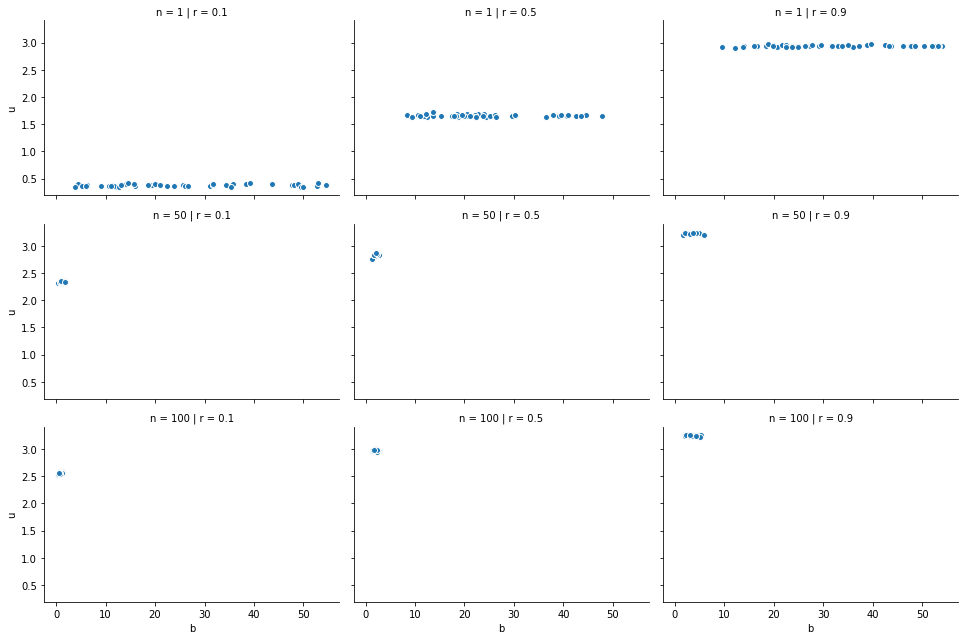

In [11]:
df_r = sim_rs(np.linspace(0.1, 0.9, 3), True)